# Demo of `jax.jit`-compatable message passing on trees

In [1]:
import jax
import jax.numpy as jnp
jax.tree_util.tree_map
import ete3

from phylax import treemp
import equinox as eqx

/opt/miniconda3/envs/gcdyn/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/opt/miniconda3/envs/gcdyn/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


## Example tree

We'll use this tree:
```ascii
           A
          / \
         B   C
        /   / \
       D   E   F
```

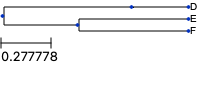

In [2]:
tree = ete3.Tree(name="A", dist=0, format=2)
tree.add_child(name="B", dist=0.7)
tree.add_child(name="C", dist=0.4)
(tree&'B').add_child(name="D", dist=0.3)
(tree&'C').add_child(name="E", dist=0.6)
(tree&'C').add_child(name="F", dist=0.6)
tree.render("%%inline")

In [3]:
from jax.experimental.sparse import BCOO

In [4]:
class Messenger(eqx.Module):
    def __call__(self, child_representations, parent_features):
        return jnp.sum(jnp.asarray(child_representations), axis=0)

class Updater(eqx.Module):
    def __call__(self, node_features, message):
        return node_features + message

In [5]:
message_passer = treemp.TreeMessagePasser(tree, ("dist",), up_messenger=Messenger(), updater=Updater())

representations = message_passer.initialize_representations(tree, lambda node: [1.0] if node.is_leaf() else [0.0])
representations


Array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [6]:
message_passer.features

Array([[0.3],
       [0.7],
       [0.6],
       [0.6],
       [0.4],
       [0. ]], dtype=float32)

In [7]:
message_passer.decorate(representations, tree, "representation")

for node in tree.traverse(strategy="postorder"):
    print(node.name, node.representation)

D [1.]
B [0.]
E [1.]
F [1.]
C [0.]
A [0.]


In [12]:
representations, representations_trajectory = message_passer.upward(representations)

assert jnp.all(representations == representations_trajectory[-1])

representations

Array([[0.3],
       [1. ],
       [0.6],
       [0.6],
       [1.6],
       [2.6]], dtype=float32)

In [9]:
@jax.jit
def foo(passer):
    return passer.features[:2].sum()

eqx.filter_grad(foo)(message_passer).updater

Updater()

In [10]:
eqx.nn.Pool(1.0, lambda x, y: x + y, 1, 1)(jnp.ones((3, 2)))

Array([[2., 2.],
       [2., 2.],
       [2., 2.]], dtype=float32)

In [11]:
message_passer._aggregate(messages, 5)
# message_passer.aggregator(*messages[message_passer.children[0]])
# # message_passer.children[1].todense().astype(bool)

AttributeError: 'TreeMessagePasser' object has no attribute '_aggregate'

## Data

We want to pass messages from leaves to root, so we'll store the following node data in post-order:
- a feature vector for each node (log-Gaussian noise in this example)
- adjacency (including self)

In [6]:
post_order_idxs = {node: idx for idx, node in enumerate(tree.traverse(strategy="postorder"))}
leaf_idxs = jnp.array([post_order_idxs[node] for node in post_order_idxs if node.is_leaf()])

n = len(post_order_idxs)
d = 3  # dimension of node features
features = jnp.exp(jax.random.normal(jax.random.PRNGKey(seed=0), shape=(n, d)))
display(features)

adjacency = jnp.zeros((n, n), dtype=bool)
for node, idx in post_order_idxs.items():
    adjacency = adjacency.at[idx, post_order_idxs[node]].set(True)
    for child in node.children:
        adjacency = adjacency.at[idx, post_order_idxs[child]].set(True)
# children = [jnp.array([post_order_idxs[child] for child in node.children], dtype=int) for node in post_order_idxs]
display(adjacency)

Array([[0.4181907 , 0.8729431 , 0.17108512],
       [1.2530419 , 0.26544216, 0.5251214 ],
       [2.6064992 , 0.96423304, 0.1592524 ],
       [0.28525436, 0.2786954 , 0.79312176],
       [0.7822064 , 1.3670146 , 2.9621491 ],
       [1.057348  , 0.65545595, 0.32428485]], dtype=float32)

Array([[ True, False, False, False, False, False],
       [ True,  True, False, False, False, False],
       [False, False,  True, False, False, False],
       [False, False, False,  True, False, False],
       [False, False,  True,  True,  True, False],
       [False,  True, False, False,  True,  True]], dtype=bool)

## Message passing

### Message aggregation and feature update functions

Example functions to aggregate messages from children and update messages for different kinds of events.

In [4]:
def aggregate(messages, adjacency):
    return jnp.where(adjacency, messages, 1).prod()

In [5]:
def update(features, messages, adjacency):
    feature_idx = adjacency.sum() - 1  # uses a different feature for each node type (leaf, mutation, birth)
    return features[feature_idx] * aggregate(messages, adjacency)

### Propagate messages up the tree

Initialize messages to log-Gaussian noise at the leaves and 1 at the internal nodes

In [6]:
messages = jnp.ones(n)
messages = messages.at[leaf_idxs].set(jnp.exp(jax.random.normal(jax.random.PRNGKey(seed=0), shape=(len(leaf_idxs),))))
messages

Array([6.147751  , 1.        , 0.61716235, 1.4047918 , 1.        ,
       1.        ], dtype=float32)

Propagate function

In [8]:
def propagate_messages(messages, node_idx):
    messages = messages.at[node_idx].set(update(features[node_idx], messages, adjacency[node_idx]))
    return messages, messages

Propagate up the tree with [`jax.lax.scan`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html#jax.lax.scan)

In [11]:
messages, message_trajectory = jax.lax.scan(propagate_messages, messages, jnp.arange(n))
assert all(messages == message_trajectory[-1])
messages

Array([1.8802418e-01, 1.1600808e-03, 2.8485893e+01, 9.3012452e-03,
       2.2458050e+00, 1.3183665e-06], dtype=float32)